## Create the regions

### Parameters

In [1]:
import numpy as np

DESIRED_REGION_SIZE_KM: np.float64 = 1.0

### Get domain bounding box

NW = -29.94800400, -51.26576000 	NE = -29.94800400, -51.04169000
SW = -30.24464000, -51.26576000 	SE = -30.24464000, -51.04169000
Width (Longitude):	21.52401857 km /	 0.22407000 deg
Height (Latitude):	32.98441826 km /	 0.29663600 deg


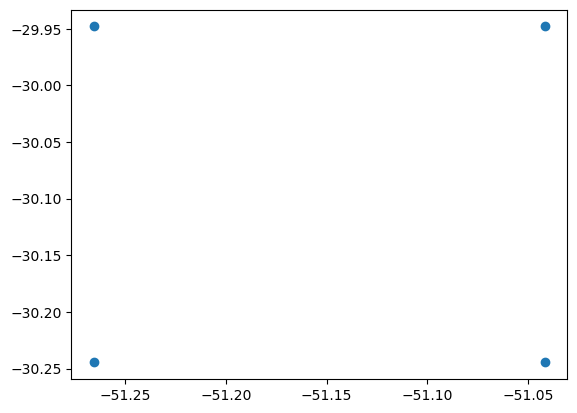

In [2]:
import matplotlib.pyplot as plt
from dataset_objects.bbox import BoundingBox
from remote.remote import Remote

whole_region_bbox: BoundingBox = Remote.get_bounding_box()
whole_region_bbox.summary()

plt.scatter(
    [whole_region_bbox.north_east.longitude, whole_region_bbox.north_west.longitude, whole_region_bbox.south_east.longitude, whole_region_bbox.south_west.longitude],
    [whole_region_bbox.north_east.latitude, whole_region_bbox.north_west.latitude, whole_region_bbox.south_east.latitude, whole_region_bbox.south_west.latitude]
)
plt.show()

### Calculate south-west points

Matrix will be 33 cells high and 22 cells wide.


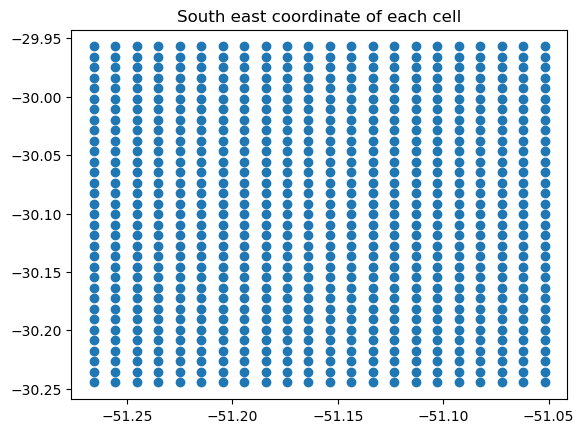

In [3]:
cells_height:int = round(whole_region_bbox.height / DESIRED_REGION_SIZE_KM)
cells_width:int = round(whole_region_bbox.width / DESIRED_REGION_SIZE_KM)

print(f'Matrix will be {cells_height} cells high and {cells_width} cells wide.')
bases_x = [((x / cells_width) * (whole_region_bbox.south_east.longitude - whole_region_bbox.south_west.longitude)) + whole_region_bbox.south_west.longitude
              for x in range(cells_width) for y in range(cells_height)]
bases_y = [((y / cells_height) * (whole_region_bbox.north_west.latitude - whole_region_bbox.south_west.latitude)) + whole_region_bbox.south_west.latitude
              for x in range(cells_width) for y in range(cells_height)]
plt.scatter(
    bases_x,
    bases_y
)
plt.title("South east coordinate of each cell")
plt.show()

### Create bounds based on south-west points

Difference in latitude is 0.00898897
Difference in longitude is 0.01018500


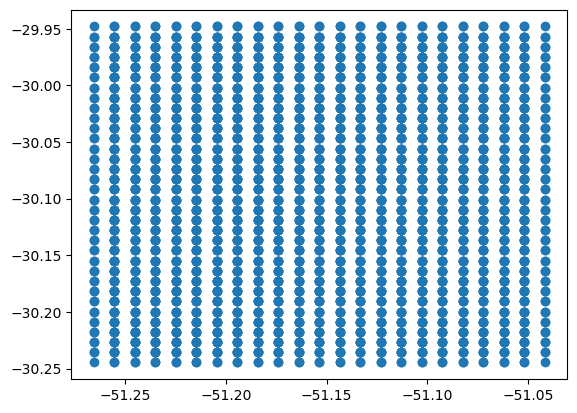

In [4]:
from dataset_objects.coordinates import Coordinates

difference_in_latitude = bases_y[1] - bases_y[0]
difference_in_longitude = bases_x[cells_height + 1] - bases_x[0]
print(f'Difference in latitude is {difference_in_latitude:.8f}')
print(f'Difference in longitude is {difference_in_longitude:.8f}')
cells = [
    [ 
        BoundingBox(
            south_west = Coordinates(
                latitude=(y * difference_in_latitude) + whole_region_bbox.south_west.latitude,
                longitude=(x * difference_in_longitude) + whole_region_bbox.south_west.longitude
            ),
            north_east = Coordinates(
                latitude=((y + 1) * difference_in_latitude) + whole_region_bbox.south_west.latitude,
                longitude=((x + 1) * difference_in_longitude) + whole_region_bbox.south_west.longitude
            ),
            x = x,
            y = y
        ) for y in range(cells_height)
    ] for x in range(cells_width)
]

bounds_x = []
bounds_y = []
for x in range(cells_width):
    for y in range(cells_height):
        cell = cells[x][y]
        bounds_x.append(cell.north_east.longitude)
        bounds_x.append(cell.south_east.longitude)
        bounds_x.append(cell.south_west.longitude)
        bounds_x.append(cell.north_west.longitude)

        bounds_y.append(cell.north_east.latitude)
        bounds_y.append(cell.south_east.latitude)
        bounds_y.append(cell.south_west.latitude)
        bounds_y.append(cell.north_west.latitude)

plt.scatter(
    bounds_x,
    bounds_y
)
plt.show()

## Create the dataset shape

### Parameters

In [5]:
F = 5 # Number of features per region [visibility, precipitation, weekday, lat, lon]
G = 2 # Number of region geographical features [lat, lon]

### Region centers

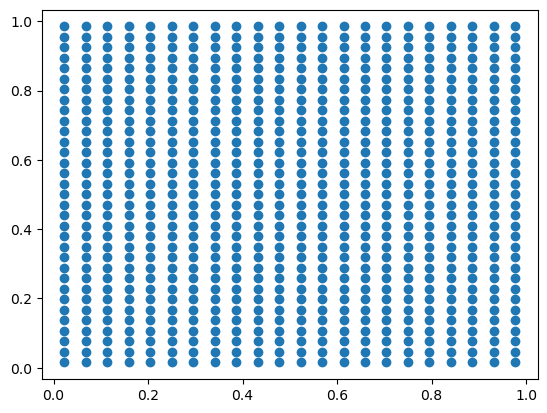

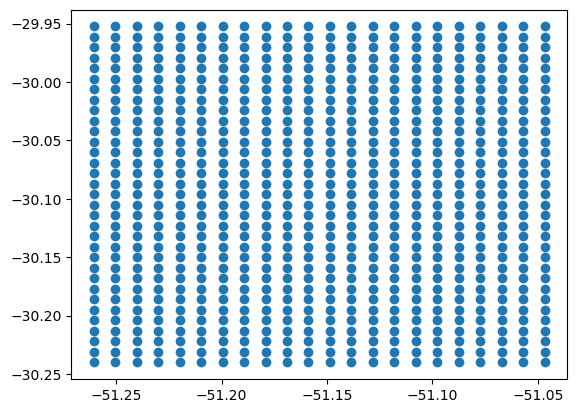

In [6]:
import matplotlib.pyplot as plt
from features.geographical.latitude import Latitude
from features.geographical.longitude import Longitude

region_centers = np.zeros(
    shape=(
        cells_width,
        cells_height,
        G
    ),
    dtype=np.float64
)

normalized_region_centers = np.zeros(
    shape=(
        cells_width,
        cells_height,
        G
    ),
    dtype=np.float64
)

normalized_x_for_plot = []
normalized_y_for_plot = []
x_for_plot = []
y_for_plot = []
for x in range(cells_width):
    for y in range(cells_height):
        region_centers[x, y, :] = cells[x][y].center.to_array()
        normalized_region_centers[x][y][0] = Latitude.create_for(cells[x][y].center, whole_region_bbox).normalize()
        normalized_region_centers[x][y][1] = Longitude.create_for(cells[x][y].center, whole_region_bbox).normalize()

        normalized_x_for_plot.append(normalized_region_centers[x][y][1])
        normalized_y_for_plot.append(normalized_region_centers[x][y][0])
        x_for_plot.append(region_centers[x][y][1])
        y_for_plot.append(region_centers[x][y][0])

plt.scatter(normalized_x_for_plot, normalized_y_for_plot)
plt.show()
plt.scatter(x_for_plot, y_for_plot)
plt.show()

### Input feature shape

In [ ]:
date_range = Remote.get_date_range()
dataset_size = len(date_range) * cells_width * cells_height

input_features = np.zeros(
    shape=(
        dataset_size,
        F
    ),
    dtype=np.float64
)

### Output shape

In [ ]:
from remote.remote import Remote
import numpy as np

date_range = Remote.get_date_range()
dataset_size = len(date_range) * cells_width * cells_height

outputs = np.zeros(
    shape=(dataset_size),
    dtype=np.float64
)

## Create the dataset

### Populate dataset

In [ ]:
from features.factory import Factory

global_index = 0
for date in date_range:

    print(f'Processing date {date}', end='\r')
    feature_matrix, output_matrix = Factory.get_risk_features(
        date,
        cells,
        whole_region_bbox,
        cells_width,
        cells_height,
        F,
        DESIRED_REGION_SIZE_KM
    )
    for xi in range(cells_width):
        for yi in range(cells_height):

            region_features = feature_matrix[xi][yi]

            input_features[global_index][:] = region_features
            outputs[global_index] = output_matrix[xi][yi]

            global_index += 1


## Save the dataset

In [ ]:
import os
import pickle as pkl

FOLDER = "data/"
INPUTS_FILE = FOLDER + "inputs.pkl"
OUTPUTS_FILE = FOLDER + "outputs.pkl"
CENTERS_FILE = FOLDER + "centers.pkl"
REGIONS_FILE = FOLDER + "regions.pkl"
N_CENTERS_FILE = FOLDER + "normal_centers.pkl"
SHAPE_FILE = FOLDER + "shape.pkl"


# Model in/out
if not os.path.exists(INPUTS_FILE):
    with open(INPUTS_FILE, 'wb') as h:
        pkl.dump(input_features, h)

if not os.path.exists(OUTPUTS_FILE):
    with open(OUTPUTS_FILE, 'wb') as h:
        pkl.dump(outputs, h)

# Region persistence
if not os.path.exists(CENTERS_FILE):
    with open(CENTERS_FILE, 'wb') as h:
        pkl.dump(region_centers, h)

if not os.path.exists(N_CENTERS_FILE):
    with open(N_CENTERS_FILE, 'wb') as h:
        pkl.dump(normalized_region_centers, h)

if not os.path.exists(REGIONS_FILE):
    with open(REGIONS_FILE, 'wb') as h:
        pkl.dump(cells, h)


if not os.path.exists(SHAPE_FILE):
    with open(SHAPE_FILE, 'wb') as h:
        pkl.dump([cells_width, cells_height, G, F, dataset_size], h)